In [1]:
import numpy as np
import matplotlib.pyplot as plt
from AWG_function import *

In [2]:
inst=connect_PXI()

Load TEProteus.dll from : C:\Windows\system32\TEProteus.dll
connected to: Tabor Electronics,P9484M,000002243278,1.237.0 --slot#: 8,


In [3]:
I=1/2*np.ones(480)
Q=1/2*np.zeros(480)


carrier_frequency=100E6
configurate_one_DAC(inst=inst,channel=1,carrier_frequency=carrier_frequency,trigger_channel=1)
pulse_1ns=segment(inst=inst,segnum=1)
# pulse_1ns.default_pulse(length=480,amplitude=0.5,phase=0,type='sine')
pulse_1ns.custom_pulse(I,Q)
pulse_1ns.compile_and_download_segment()


empty = segment(inst=inst, segnum=2)
empty.default_pulse(length=480, amplitude=0.5, phase=0, type='empty')
empty.compile_and_download_segment()

DAC sample rate 1.00GS/s, SCLK 8.00GS/s
DAC minimun segment length 32.0ns, segment granuality 16.0ns
DAC configuration successful
channel 1, segment 1 downloaded, length 480.0ns
channel 1, segment 2 downloaded, length 480.0ns


In [4]:
ch1_task=task_table(inst=inst,length=3)
ch1_task.new_task(tasknum=1,segnum=1,ext_trigger_ch=1,digitizer_trigger=False,next_task=2)
ch1_task.new_task(tasknum=2,segnum=2,ext_trigger_ch=0,digitizer_trigger=True,next_task=3)
ch1_task.new_task(tasknum=3,segnum=1,ext_trigger_ch=0,digitizer_trigger=False,next_task=1)
ch1_task.download_task_table()

channel 1 task table downloaded


In [5]:
ch1_digitizer=digitizer(address={'inst':inst,'channel':1},task_trigger_channel=1,carrier_frequency=carrier_frequency,numframes=1,framelen=4800)

digitizer sample rate 0.12GS/s, SCLK 2.00GS/s
digitizer granularity 384.0ns
Channel 1 acquisition frame Length 19200.0 ns, frame number 1


In [6]:
ch1_digitizer.inquire_acquisition()

(0, 0)

In [7]:
ch1_digitizer.read_digitizer_data()

Total read size in bytes: 19200
acquired 2400 complex points


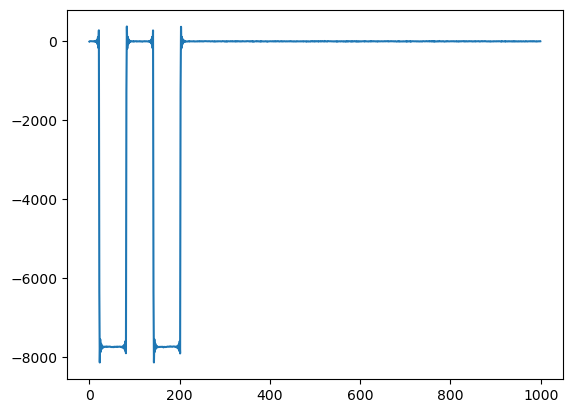

In [9]:
plt.plot(ch1_digitizer.wavQ[0:1000])

In [16]:
numframes, framelen = 1, 4800 # remember multiple of 96
totlen = numframes * framelen
print('Waveform Length {0}'.format(totlen))
wav1 = np.zeros(totlen, dtype=np.uint32)
sampleRateADC = SampleRateADC
cmd = ':DIG:MODE DUAL'
inst.send_scpi_cmd(cmd)
print('ADC Clk Freq {0}'.format(sampleRateADC))
cmd = ':DIG:FREQ  {0}'.format(sampleRateADC)
inst.send_scpi_cmd(cmd)
print('Aquisition Length {0}'.format(framelen/2/sampleRateADC*16)) # x16 decimation
resp = inst.send_scpi_query(':DIG:FREQ?')
print("Dig Frequency = ")
print(resp)
# Enable capturing data from channel 1
cmd = ':DIG:CHAN:SEL 1'
inst.send_scpi_cmd(cmd)
resp = inst.send_scpi_query(':SYST:ERR?')
print("Dig error = ")
print(resp)
cmd = ':DIG:DDC:MODE COMP'   # DDC activation to complex i+jq
inst.send_scpi_cmd(cmd)
cmd = ':DIG:DDC:CFR1 {0}'.format(100E6)
inst.send_scpi_cmd(cmd)
cmd = ':DIG:DDC:PHAS1 0'
inst.send_scpi_cmd(cmd)
cmd = ':DIG:DDC:CLKS AWG'
rc = inst.send_scpi_cmd(cmd)
resp = inst.send_scpi_query(':SYST:ERR?')
print("Set complex error = ")
print(resp)
cmd = ':DIG:CHAN:STATE ENAB'
inst.send_scpi_cmd(cmd)
# trigger from the task list
cmd = ':DIG:TRIG:SOURCE TASK1'
inst.send_scpi_cmd(cmd)
dig_system_delay=560E-9
cmd=':INST:CHAN:SEL 1'
inst.send_scpi_cmd(cmd)
# need to set the delay for individual output channel
cmd = ':DIG:TRIG:AWG:TDEL {0}'.format(dig_system_delay)
inst.send_scpi_cmd(cmd)
cmd = ':DIG:ACQuire:FRAM:DEF {0},{1}'.format(numframes, framelen)
inst.send_scpi_cmd(cmd)
# Select the frames for the capturing
capture_first, capture_count = 1, numframes
cmd = ':DIG:ACQuire:FRAM:CAPT {0},{1}'.format(capture_first, capture_count)
inst.send_scpi_cmd(cmd)

Waveform Length 4800
ADC Clk Freq 2000000000.0
Aquisition Length 1.92e-05
Dig Frequency = 
2000000000.000
Dig error = 
0, no error
Set complex error = 
0, no error


0

In [17]:
import time
inst.send_scpi_cmd(':DIG:INIT OFF')

inst.send_scpi_cmd(':DIG:INIT ON')

cmd = '*TRG'

inst.send_scpi_cmd(cmd)

 

frameRx = 0

times = 0

while (frameRx != 1):

    resp = inst.send_scpi_query(':DIG:ACQuire:FRAM:STATus?')

    framesParam = resp.split(",")

    frameRx = int(framesParam[1])

    times += 1

    time.sleep(0.1)

    # if times > 100:

    #     break

    #     # end time and print time

    print(resp)

inst.send_scpi_cmd(':DIG:INIT OFF')

1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,1,0,1


0

Total read size in bytes: 19200

4800
2400
2400


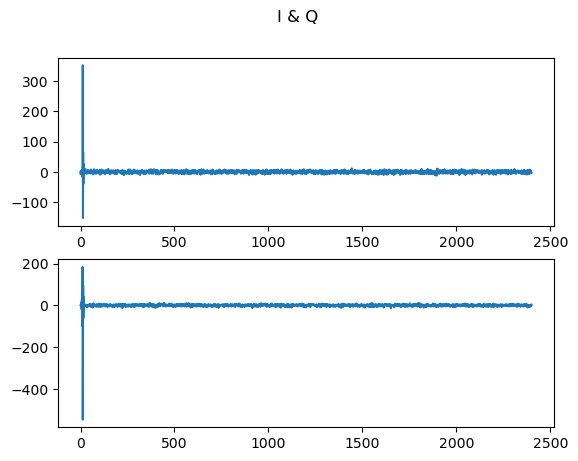

In [18]:
###############################################################################
# Choose which frames to read (all in this example)
cmd = ':DIG:DATA:SEL ALL'
inst.send_scpi_cmd(cmd)
# Choose what to read
# (only the frame-data without the header in this example)
cmd = ':DIG:DATA:TYPE FRAM'
inst.send_scpi_cmd(cmd)
# Get the total data size (in bytes)
resp = inst.send_scpi_query(':DIG:DATA:SIZE?')
num_bytes = np.uint32(resp)
print('Total read size in bytes: ' + resp)
print()
# Read the data that was captured by channel 1:
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')
wavlen = num_bytes // 2
rc = inst.read_binary_data(':DIG:DATA:READ?', wav1, wavlen)
cmd=':DIG:ACQ:ZERO:ALL 0'
inst.send_scpi_cmd(cmd)
################################################################################
wav1 = np.int32(wav1) - 16384
print(len(wav1))
wavlen = int(len(wav1)/2)
wavI=wav1[0::2]
wavQ=wav1[1::2]
wavI = wavI.astype(float)
wavQ = wavQ.astype(float)
print(len(wavI))
print(len(wavQ))
fig, axs = plt.subplots(2)
fig.suptitle('I & Q')
axs[0].plot(wavI)
axs[1].plot(wavQ)
plt.show()

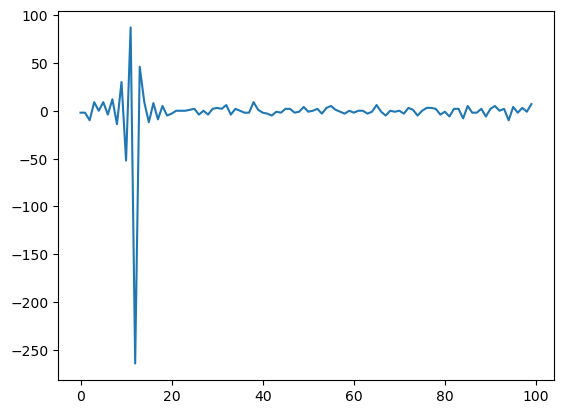

In [13]:
inst.send_scpi_query(':VOLT?')

'0.5'

In [6]:
(0.25)**2/2/50

0.000625